In [2]:
%pylab inline

import theano
import theano.tensor.signal.downsample

from fuel.transformers import ScaleAndShift, Cast
from fuel.streams import DataStream
from fuel.schemes import ShuffledScheme, SequentialScheme

from blocks import *

import time

Populating the interactive namespace from numpy and matplotlib


Using gpu device 0: GeForce GTX 780 (CNMeM is enabled)


In [42]:
### Generic config

Config = {'batchsize-train' : 100,
          'batchsize-validation' : 100,
          'batchsize-test' : 100,
          'theano-debug' : False,
         }

theano.config.floatX = 'float32'
theano.config.compute_test_value = 'off'
if Config['theano-debug']:
    print "Set Theano to debug mode."
    theano.config.optimizer = 'fast_compile'
    theano.config.exception_verbosity = 'high'
else:
    theano.config.optimizer = 'fast_run'
    theano.config.exception_verbosity = 'low'


In [57]:
from fuel.datasets.cifar10 import CIFAR10

CIFAR10.default_transformers = (
    (ScaleAndShift, [2.0 / 255.0, -1], {'which_sources': 'features'}),
    (Cast, [np.float32], {'which_sources': 'features'})
)

Data_Train      = CIFAR10(("train",), subset=slice(None ,40000))
Data_Validation = CIFAR10(("train",), subset=slice(40000, None))
Data_Test       = CIFAR10(("test" ,)                           )

Stream_Train     = DataStream.default_stream(
                      Data_Train,
                      iteration_scheme=ShuffledScheme(Data_Train.num_examples       , Config['batchsize-train'])
                   )
Stream_Validation = DataStream.default_stream(
                      Data_Validation,
                      iteration_scheme=SequentialScheme(Data_Validation.num_examples, Config['batchsize-validation'])
                   )
Stream_Test       = DataStream.default_stream(
                      Data_Test,
                      iteration_scheme=SequentialScheme(Data_Test.num_examples      , Config['batchsize-test'])
                   )

print "Loaded input data."
print "Subset sizes: Train %d, Validation %d, Test %d" % (Data_Train.num_examples, Data_Validation.num_examples, Data_Test.num_examples)

def GetNextBatch(stream):
    return next(stream.get_epoch_iterator())

print "Stream data shapes:"
x,y = GetNextBatch(Stream_Train)
print "Stream_Train: image batch of shape %s [%s], and label batch of shape %s [%s]" % (x.shape, x.dtype, y.shape, y.dtype)
x,y = GetNextBatch(Stream_Test)
print "Stream_Test: image batch of shape %s [%s], and label batch of shape %s [%s]" % (x.shape, x.dtype, y.shape, y.dtype)

Loaded input data.
Subset sizes: Train 40000, Validation 10000, Test 10000
Stream data shapes:
Stream_Train: image batch of shape (100, 3, 32, 32) [float32], and label batch of shape (100, 1) [uint8]
Stream_Test: image batch of shape (100, 3, 32, 32) [float32], and label batch of shape (100, 1) [uint8]


In [58]:
class Layer_Conv2D_NoBias():
    def __init__(self, in_sets, out_sets, kern_size = 5):
        self.in_sets, self.out_sets, self.kern_size = in_sets, out_sets, kern_size
    def build(self, input, n):
        Kern = theano.shared(np.zeros((self.out_sets,self.in_sets,self.kern_size,self.kern_size), dtype='float32'), name=("CW%d" % n))
        Kern.tag.initializer = IsotropicGaussian(0.001)
        out = theano.tensor.nnet.conv2d(input, Kern, filter_shape=(self.kern_size,self.kern_size))
        return out, [Kern], [], ('conv2d',True,False)

class Layer_Pool2D():
    def __init__(self, pool_size):
        self.pool_size = pool_size
    def build(self, input, n):
        out = theano.tensor.signal.downsample.max_pool_2d(input, (self.pool_size,self.pool_size), ignore_border=True)
        return out, [], [], ('pool2d',True,False)
    
class Layer_Sigmoid():
    def __init__(self):
        pass
    def build(self, input, n):
        sigm = theano.tensor.nnet.sigmoid(input)
        return sigm, [], [], ('sigm',True,True)

class Layer_ReLU():
    def __init__(self):
        pass
    def build(self, input, n):
        relu = theano.tensor.maximum(0.0, input)
        return relu, [], [], ('relu',True,True)

class Layer_BN():
    def __init__(self, size, alpha=0.6):
        self.size, self.alpha = size, alpha
    def build(self, input, n):
        Gamma = theano.shared(np.zeros((self.size,), dtype='float32'), name=("NG%d" % n))
        Beta  = theano.shared(np.zeros((self.size,), dtype='float32'), name=("NB%d" % n))
        Gamma.tag.initializer = Constant(1.0)
        Beta.tag.initializer = Constant(0.0)
    
        means = theano.tensor.mean(input, 0, keepdims=True)
        stds = theano.tensor.std(input, 0, keepdims=True)
        
        normalized = (input - means)/(stds + 0.0001)
        normalized = normalized * Gamma.dimshuffle('x',0) + Beta.dimshuffle('x',0)
        
        return normalized, [Beta, Gamma], [], ('bn',False,False)
    
class Layer_BN_2D():
    def __init__(self, size, alpha=0.6):
        self.size, self.alpha = size, alpha
    def build(self, input, n):
        Gamma = theano.shared(np.zeros((self.size,), dtype='float32'), name=("NG%d" % n))
        Beta  = theano.shared(np.zeros((self.size,), dtype='float32'), name=("NB%d" % n))
        Gamma.tag.initializer = Constant(1.0)
        Beta.tag.initializer = Constant(0.0)
    
        means = theano.tensor.mean(input, (0,2,3), keepdims=True)
        stds = theano.tensor.std(input, (0,2,3), keepdims=True)
        
        normalized = (input - means)/(stds + 0.0001)
        normalized = normalized * Gamma.dimshuffle('x',0,'x','x') + Beta.dimshuffle('x',0,'x','x')
        
        return normalized, [Beta, Gamma], [], ('bn2d',False,False)


class Layer_FullyConnected():
    def __init__(self, in_sets, out_sets):
        self.in_sets, self.out_sets = in_sets, out_sets
    def build(self, input, n):
        W    = theano.shared(np.zeros((self.in_sets, self.out_sets), dtype='float32'), name=("FW%d" % n))
        Bias = theano.shared(np.zeros((self.out_sets,), dtype='float32'), name=("FB%d" % n))
        W.tag.initializer = IsotropicGaussian(0.05)
        Bias.tag.initializer = Constant(0.0)
        out = theano.tensor.dot(input, W) + Bias.dimshuffle('x',0)
        return out, [W, Bias], [], ('fc',False,False)

class Layer_FullyConnected_NoBias():
    def __init__(self, in_sets, out_sets):
        self.in_sets, self.out_sets = in_sets, out_sets
    def build(self, input, n):
        W    = theano.shared(np.zeros((self.in_sets, self.out_sets), dtype='float32'), name=("FW%d" % n))
        W.tag.initializer = IsotropicGaussian(0.05)
        out = theano.tensor.dot(input, W)
        return out, [W], [], ('fcnb',False,False)

class Layer_2Dto1D():
    def __init__(self):
        pass
    def build(self, input, n):
        return input.flatten(2), [], [], ('2to1',False,False)
class Layer_DebugPeek():
    def __init__(self):
        pass
    def build(self, input, n):
        return input, [], [input], ('debug',True,True)

In [59]:
class NetworkBuilder():
    def __init__(self, layerlist):
        self.layers = layerlist
    def build(self, input):
        self.middle_layers = []
        self.middle_tags = []
        params, debug = [], []
        current = input
        i = 0
        for layer in self.layers:
            current, p, u, t = layer.build(current, i)
            params += p
            debug += u
            i += 1
            self.middle_layers += [current]
            self.middle_tags += [t]
        return current, params, debug

In [46]:
# Network topology
"""
 # reached 76%                                                                   # Sample size
q1, p1 = Layer_Conv2d_ReLU_Pool2D (Input_X,   3,  32, "CW1", "CB1", kern_size=5) # 32x32 -> 14x14
q2, p2 = Layer_Conv2d_ReLU_Pool2D (q1     ,  32,  64, "CW2", "CB2", kern_size=5) # 14x14 ->  5x 5
q3, p3 = Layer_Conv2d_ReLU_Pool2D (q2     ,  64, 128, "CW3", "CB3", pool_size=1) #  5x 5 ->  1x 1
q4, p4 = Layer_FullyConnected_ReLU(q3     , 128, 512, "FW4", "FB4")
q5, p5 = Layer_FullyConnected     (q4     , 512,  10, "FW5", "FB5")

ParamList  = p1 + p2 + p3 + p4 + p5

"""
                                                                                 # Sample size
q1, p1 = Layer_Conv2d_BN_ReLU_Pool2D (Input_X,   3,  32, "CW1", "CG1", "CB1", kern_size=5) # 32x32 -> 14x14
q2, p2 = Layer_Conv2d_BN_ReLU_Pool2D (q1     ,  32,  64, "CW2", "CG2", "CB2", kern_size=5) # 14x14 ->  5x 5
q3, p3 = Layer_Conv2d_BN_ReLU_Pool2D (q2     ,  64, 128, "CW3", "CG3", "CB3", pool_size=1) #  5x 5 ->  1x 1
q3 = q3.flatten(2)
q4, p4 = Layer_FullyConnected_NoBias(q3     , 128, 512, "FW4")
q5, p5 = Layer_BN(q4, 512, "_G5","_B5")
q6, p6 = Layer_ReLU(q5)
q7, p7 = Layer_FullyConnected           (q6     , 512,  10, "FW7", "FB7")

q1, p1 = Layer_Conv2d_NoBias(Input_X, 3, 32, "CW1", kern_size=5)
q2, p2 = Layer_BN_2D(q1, 32, "CG2", "CB2")
q3, p3 = Layer_ReLU(q2)
q4, p4 = Layer_Pool2D(q3,2)
q5, p5 = Layer_Conv2d_NoBias(q4, 32, 64, "CW5", kern_size=5)
q6, p6 = Layer_BN_2D(q5, 32, "CG6", "CB6")
q7, p7 = Layer_ReLU(q6)
q8, p8 = Layer_Pool2D(q7,2)

NameError: name 'Layer_Conv2d_BN_ReLU_Pool2D' is not defined

In [98]:
Input_X = theano.tensor.tensor4('X')
Input_Y = theano.tensor.matrix('Y', dtype='uint8')


network = NetworkBuilder([
        Layer_Conv2D_NoBias(3, 32, kern_size=5),
        Layer_BN_2D(32),
        Layer_ReLU(),
        Layer_Pool2D(pool_size=2),
        Layer_Conv2D_NoBias(32, 64, kern_size=5),
        Layer_BN_2D(64),
        Layer_ReLU(),
        Layer_Pool2D(pool_size=2),
        Layer_Conv2D_NoBias(64, 128, kern_size=5),
        Layer_2Dto1D(),
        Layer_BN(128),
        Layer_ReLU(),
        Layer_FullyConnected_NoBias(128,512),
        Layer_BN(512),
        Layer_ReLU(),
        Layer_FullyConnected(512,10)
    ])

network = NetworkBuilder([
        Layer_Conv2D_NoBias(3, 64, kern_size=5),
        Layer_BN_2D(64),
        Layer_Sigmoid(),
        Layer_Pool2D(pool_size=2),
        Layer_Conv2D_NoBias(64, 64, kern_size=5),
        Layer_BN_2D(64),
        Layer_Sigmoid(),
        Layer_Pool2D(pool_size=2),
        Layer_Conv2D_NoBias(64, 128, kern_size=5),
        Layer_2Dto1D(),
        Layer_BN(128),
        Layer_Sigmoid(),
        Layer_FullyConnected(128,10)
    ])

network = NetworkBuilder([
        Layer_Conv2D_NoBias(3, 64, kern_size=3),
        Layer_BN_2D(64),
        Layer_Sigmoid(),
        Layer_Pool2D(pool_size=3),
        Layer_Conv2D_NoBias(64, 64, kern_size=3),
        Layer_BN_2D(64),
        Layer_Sigmoid(),
        Layer_Pool2D(pool_size=2),
        Layer_Conv2D_NoBias(64, 128, kern_size=3),
        Layer_BN_2D(128),
        Layer_Sigmoid(),
        Layer_Pool2D(pool_size=2),
        Layer_2Dto1D(),
        Layer_FullyConnected_NoBias(128,512),
        Layer_BN(512),
        Layer_Sigmoid(),
        Layer_FullyConnected(512,10)
    ])

network = NetworkBuilder([
        Layer_Conv2D_NoBias(3, 64, kern_size=3),
        Layer_BN_2D(64),
        Layer_ReLU(),
        Layer_Pool2D(pool_size=3),
        Layer_Conv2D_NoBias(64, 128, kern_size=3),
        Layer_BN_2D(128),
        Layer_ReLU(),
        Layer_Pool2D(pool_size=2),
        Layer_2Dto1D(),
        Layer_FullyConnected_NoBias(128*4*4,1024),
        Layer_BN(1024),
        Layer_ReLU(),
        Layer_FullyConnected_NoBias(1024,128),
        Layer_BN(128),
        Layer_Sigmoid(),
        Layer_FullyConnected(128,10)
    ])

out, ParamList, Debug_Vars = network.build(Input_X)

Output_Probabilities = theano.tensor.nnet.softmax(out)

Output_Predictions   = theano.tensor.argmax(Output_Probabilities, axis=1)

Output_ErrRate = theano.tensor.neq(Output_Predictions,Input_Y.ravel()).mean()
Output_NLL     = - theano.tensor.log(Output_Probabilities[theano.tensor.arange(Input_Y.shape[0]), Input_Y.ravel()]).mean()

# wdecay_alpha = 3e-3
# wdecay_alpha = 1e-2
wdecay_alpha = 4e-2

Output_WeightDecay = 0.0
for p in ParamList:
    if p.name[1] == 'W':
        Output_WeightDecay = Output_WeightDecay + wdecay_alpha * (p**2).sum()

Output_Cost = Output_NLL + Output_WeightDecay


In [99]:
# The updates will update our shared values
updates = []

Input_LRate    = theano.tensor.scalar('lrate',dtype='float32')
Input_Momentum = theano.tensor.scalar('momentum',dtype='float32')

# Theano will compute the gradients for us
Model_Gradients = theano.grad(Output_Cost, ParamList)

#initialize storage for momentum
Model_Velocities = [theano.shared(np.zeros_like(p.get_value()), name='V_%s' %(p.name, )) for p in ParamList]

for p,g,v in zip(ParamList, Model_Gradients, Model_Velocities):
    v_new = Input_Momentum * v - Input_LRate * g
    p_new = p + v_new
    updates += [(v,v_new), (p, p_new)]
    

In [100]:
#compile theano functions

#each call to train step will make one SGD step
Function_TrainStep = theano.function(
    [Input_X,Input_Y,Input_LRate,Input_Momentum],
    [Output_Cost, Output_ErrRate, Output_NLL, Output_WeightDecay],
    updates=updates,
    allow_input_downcast=True
)
Function_TrainStep_Debug = theano.function(
    [Input_X,Input_Y,Input_LRate,Input_Momentum],
    [Output_Cost, Output_ErrRate, Output_NLL, Output_WeightDecay] + Debug_Vars,
    updates=updates,
    allow_input_downcast=True
)
#each call to predict will return predictions on a batch of data
Function_Predict = theano.function(
    [Input_X],
    Output_Predictions
)

INFO (theano.gof.compilelock): Refreshing lock /tmp/i258385/theano.NOBACKUP/nn_compiledir_Linux-3.13.0-32-generic-x86_64-with-debian-jessie-sid-x86_64-2.7.10-64/lock_dir/lock
INFO:theano.gof.compilelock:Refreshing lock /tmp/i258385/theano.NOBACKUP/nn_compiledir_Linux-3.13.0-32-generic-x86_64-with-debian-jessie-sid-x86_64-2.7.10-64/lock_dir/lock


In [101]:
rng = numpy.random.RandomState(42)

def compute_error_rate(stream):
    errs = 0.0
    num_samples = 0.0
    for X, Y in stream.get_epoch_iterator():
        errs += (Function_Predict(X)!=Y.ravel()).sum()
        num_samples += Y.shape[0]
    return errs/num_samples

def init_parameters():
    global rng
    for p in ParamList:
        p.set_value(p.tag.initializer.generate(rng, p.get_value().shape))

def snapshot_parameters():
    return [p.get_value(borrow=False) for p in ParamList]

def load_parameters(snapshot):
    for p, s in zip(ParamList, snapshot):
        p.set_value(s, borrow=False)

In [102]:
i=0
e=0

init_parameters()
for v in Model_Velocities:
    v.set_value(np.zeros_like(v.get_value()))

Training_Best_ErrRate = np.inf
Training_Best_Params = snapshot_parameters()
Training_Best_Epoch = 0

train_erros = []
train_loss = []
train_nll = []
validation_errors = []

number_of_epochs = 3
patience_expansion = 1.5

Training_StartTime = time.time()

print Debug_Vars

while e<number_of_epochs: #This loop goes over epochs
    e += 1
    #First train on all data from this batch
    epoch_start_i = i
    
    epoch_starttime = time.time()
    for X_batch, Y_batch in Stream_Train.get_epoch_iterator(): 
        i += 1
        
        K = 2000
        # lrate = 4e-3 * K / np.maximum(K, i)
        lrate = 4e-3 * K / np.maximum(K, i)
        momentum = 0.9
        
        # momentum = 1.0 - np.maximum(np.minimum(200.0/(i+1), 0.4), 0.01)
        if i % 1000 == 1000000:
            t = Function_TrainStep_Debug(X_batch, Y_batch, lrate, momentum)
            L, err_rate, nll, wdec = t[0:4]
            debugvars = t[4:]
            for a in debugvars:
                dir(a)
                array = np.array(a)
                print array
        else:
            L, err_rate, nll, wdec = Function_TrainStep(X_batch, Y_batch, lrate, momentum)
        
        train_loss.append((i,L))
        train_erros.append((i,err_rate))
        train_nll.append((i,nll))
        if i % 1000 == 0:
            print "At minibatch %d, batch loss %f, batch nll %f, batch error rate %f%%" % (i, L, nll, err_rate*100)
        
    epoch_endtime = time.time()
    print "Time per epoch: %ss" % (epoch_endtime - epoch_starttime)
    # After an epoch compute validation error
    val_error_rate = compute_error_rate(Stream_Validation)
    if val_error_rate < Training_Best_ErrRate:
        number_of_epochs = np.maximum(number_of_epochs, e * patience_expansion+1)
        Training_Best_ErrRate = val_error_rate
        Training_Best_Params = snapshot_parameters()
        Training_Best_Epoch = e
    validation_errors.append((i,val_error_rate))
    print "After epoch %d: valid_err_rate: %f%% currently going to do %d epochs" %(
        e, val_error_rate*100, number_of_epochs)
    print "After epoch %d: averaged train_err_rate: %f%% averaged train nll: %f averaged train loss: %f" %(
        e, np.mean(np.asarray(train_erros)[epoch_start_i:,1])*100, 
        np.mean(np.asarray(train_nll)[epoch_start_i:,1]),
        np.mean(np.asarray(train_loss)[epoch_start_i:,1]))

Training_EndTime = time.time()
print "TOTAL TIME: %ss" % int(Training_EndTime - Training_StartTime)

[]
Time per epoch: 17.5482001305s
After epoch 1: valid_err_rate: 50.790000% currently going to do 3 epochs
After epoch 1: averaged train_err_rate: 57.620000% averaged train nll: 1.818833 averaged train loss: 85.424395
Time per epoch: 17.5188660622s
After epoch 2: valid_err_rate: 41.900000% currently going to do 4 epochs
After epoch 2: averaged train_err_rate: 45.240000% averaged train nll: 1.470874 averaged train loss: 7.711459
At minibatch 1000, batch loss 1.980589, batch nll 1.281886, batch error rate 38.000000%
Time per epoch: 17.525703907s
After epoch 3: valid_err_rate: 38.180000% currently going to do 5 epochs
After epoch 3: averaged train_err_rate: 39.925000% averaged train nll: 1.332311 averaged train loss: 2.128714
Time per epoch: 17.5200879574s
After epoch 4: valid_err_rate: 39.010000% currently going to do 5 epochs
After epoch 4: averaged train_err_rate: 38.125000% averaged train nll: 1.274415 averaged train loss: 1.723771
At minibatch 2000, batch loss 1.537987, batch nll 1.0

KeyboardInterrupt: 

Setting network parameters from after epoch 43
Test error rate is 22.090000%
Success rate is 77.910000%


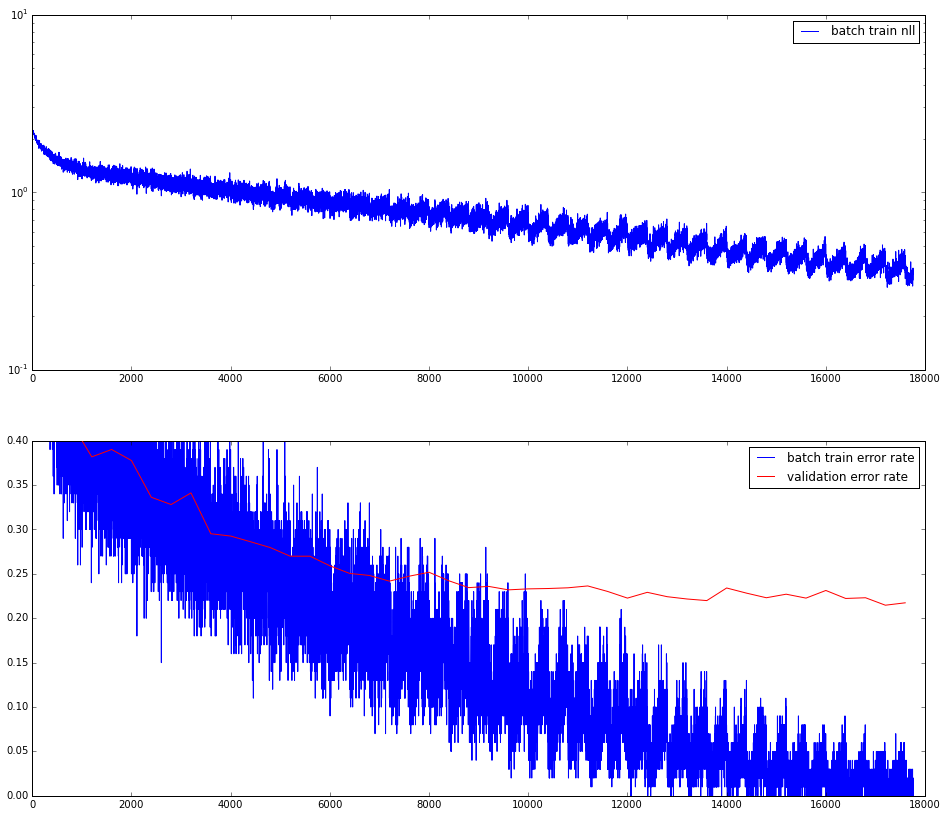

In [103]:
print "Setting network parameters from after epoch %d" %(Training_Best_Epoch)
load_parameters(Training_Best_Params)

print "Test error rate is %f%%" %(compute_error_rate(Stream_Test)*100.0,)
print "Success rate is %f%%" %(100.0 - compute_error_rate(Stream_Test)*100.0,)

figure(figsize=(16,14))

subplot(2,1,1)
train_nll_a = np.array(train_nll)
semilogy(train_nll_a[:,0], train_nll_a[:,1], label='batch train nll')
legend()

subplot(2,1,2)
train_erros_a = np.array(train_erros)
plot(train_erros_a[:,0], train_erros_a[:,1], label='batch train error rate', zorder=0)
validation_errors_a = np.array(validation_errors)
plot(validation_errors_a[:,0], validation_errors_a[:,1], label='validation error rate', color='r', zorder=10)
ylim(0,0.4)
legend()

In [89]:
mid = network.middle_layers
print mid
middle_layers_computer = theano.function([Input_X], [Input_X] + mid)



INFO (theano.gof.compilelock): Refreshing lock /tmp/i258385/theano.NOBACKUP/nn_compiledir_Linux-3.13.0-32-generic-x86_64-with-debian-jessie-sid-x86_64-2.7.10-64/lock_dir/lock
INFO:theano.gof.compilelock:Refreshing lock /tmp/i258385/theano.NOBACKUP/nn_compiledir_Linux-3.13.0-32-generic-x86_64-with-debian-jessie-sid-x86_64-2.7.10-64/lock_dir/lock


[AbstractConv2d{border_mode='valid', subsample=(1, 1), filter_flip=True, imshp=None, kshp=(3, 3)}.0, Elemwise{add,no_inplace}.0, Elemwise{maximum,no_inplace}.0, DownsampleFactorMax{ds=(3, 3), ignore_border=True, st=(3, 3), padding=(0, 0), mode='max'}.0, AbstractConv2d{border_mode='valid', subsample=(1, 1), filter_flip=True, imshp=None, kshp=(3, 3)}.0, Elemwise{add,no_inplace}.0, Elemwise{maximum,no_inplace}.0, DownsampleFactorMax{ds=(2, 2), ignore_border=True, st=(2, 2), padding=(0, 0), mode='max'}.0, Reshape{2}.0, dot.0, Elemwise{add,no_inplace}.0, Elemwise{maximum,no_inplace}.0, dot.0, Elemwise{add,no_inplace}.0, sigmoid.0, Elemwise{add,no_inplace}.0]


(100, 3, 32, 32)


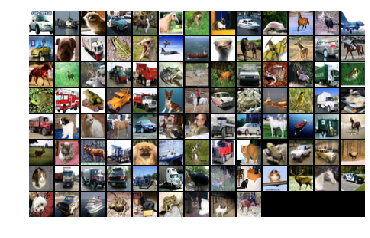

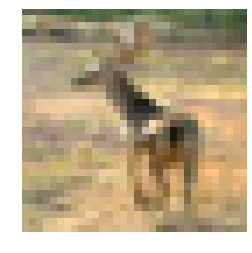

conv2d (64, 1, 30, 30)


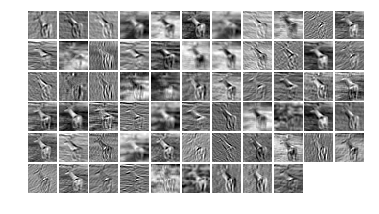

relu (64, 1, 30, 30)


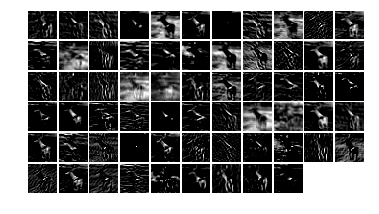

pool2d (64, 1, 10, 10)


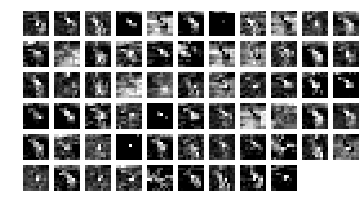

conv2d (128, 1, 8, 8)


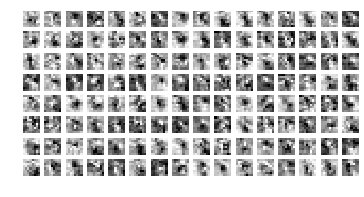

relu (128, 1, 8, 8)


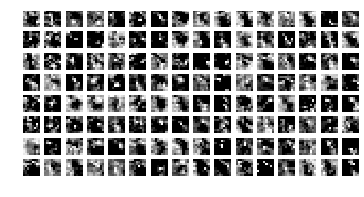

pool2d (128, 1, 4, 4)


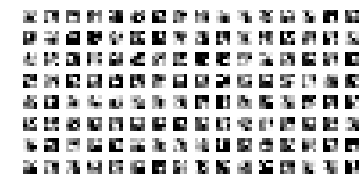

relu (1, 1, 1024, 1)


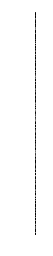

sigm (1, 1, 128, 1)


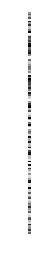

end


In [97]:

from common.plotting import plot_mat
test_batch, _ = GetNextBatch(Stream_Validation)
print test_batch.shape
plot_mat(test_batch)
show()

middle_layers = middle_layers_computer(test_batch)
i = 23

original = test_batch[i:i+1]
plot_mat(original)
show()

for layer, tag in zip(middle_layers[1:], network.middle_tags):
    if tag[1]:
        try:
            testimg = layer[i:i+1].transpose(1,0,2,3)
        except ValueError:
            testimg = layer[i:i+1][...,np.newaxis,np.newaxis]
        if testimg.shape[3] == 1:
            testimg = testimg.transpose(2,3,1,0)
        print tag[0], testimg.shape
        plot_mat(testimg, cmap='gray')
        show()
    
print 'end'